# MODULE 4
## Milestone 1: exploration phase

In [44]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import Tuple
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics

plt.style.use("ggplot")

In [2]:
box_builder_sample_data = '/home/unai/datasets/feature_frame.csv'
bb_df = pd.read_csv(box_builder_sample_data)
bb_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [3]:
bb_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [4]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [3]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in bb_df.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [4]:
# We only keep orders with at least 5 items
orders = bb_df['order_id'].unique()
orders_more5 = orders[bb_df.groupby('order_id')['outcome'].sum() >= 5]
bb_df = bb_df.loc[bb_df['order_id'].isin(orders_more5)]

In [16]:
# We take a subsample of the entire dataset because is too big
bb_df_subsample = bb_df[(pd.DatetimeIndex(bb_df['order_date']).year == 2021) & (pd.DatetimeIndex(bb_df['order_date']).month > 1)]

In [18]:
# We avoid information leakage in train and test datasets of different orders
orders = bb_df_subsample['order_id'].unique()
orders_train, orders_validation, orders_test = np.split(orders, [int(.75 * len(orders)), int(.9 * len(orders))])

In [24]:
train = bb_df_subsample[bb_df_subsample['order_id'].isin(orders_train)].reset_index()
X_train = train[features_cols]
Y_train = train[label_col]

validation = bb_df_subsample[bb_df_subsample['order_id'].isin(orders_validation)].reset_index()
X_validation = validation[features_cols]
Y_validation = validation[label_col]

test = bb_df_subsample[bb_df_subsample['order_id'].isin(orders_test)].reset_index()
X_test = test[features_cols]
Y_test = test[label_col]

In [25]:
print(f"Value counts train: {(Y_train.value_counts()/len(Y_train)*100).to_dict()}")
print(f"Value counts validation: {(Y_validation.value_counts()/len(Y_validation)*100).to_dict()}")
print(f"Value counts test: {(Y_test.value_counts()/len(Y_test)*100).to_dict()}")

Value counts train: {0.0: 98.66201946778872, 1.0: 1.3379805322112794}
Value counts validation: {0.0: 98.64724721671496, 1.0: 1.3527527832850388}
Value counts test: {0.0: 98.84481747213573, 1.0: 1.155182527864266}


We mantain the balance

## TRAINING DIFFERENT MODELS

In [26]:
train_columns = numerical_cols + binary_cols

### DECISION TREE

First, we are going to try with the selected variables in the linear model

In [27]:
linear_columns = ['abandoned_before', 'ordered_before', 'global_popularity', 'user_order_seq', 'normalised_price']

In [45]:
# We don't need to standarize the variables as decision trees are not affected by feature scale
dec_tree = tree.DecisionTreeClassifier()
dec_tree.fit(X_train[train_columns], Y_train)     

DecisionTreeClassifier()

In [29]:
Y_prob_dt = dec_tree.predict_proba(X_validation[train_columns])[:,1]

In [30]:
def calculate_metrics(y_prob:pd.Series, y_true:pd.Series) -> Tuple[pd.DataFrame, np.float64, pd.DataFrame, np.float64]:
    #ROC
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_true, y_prob)
    auc_roc = round(metrics.roc_auc_score(y_true, y_prob), 4)
    roc = pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds_roc})

    #Precision-Recall
    precision, recall, thresholds_precrec = metrics.precision_recall_curve(y_true, y_prob)
    auc_precrec = round(metrics.auc(recall, precision), 4)
    precision_recall = pd.DataFrame({'Precision': precision[:len(precision) - 1], 'Recall': recall[:len(recall) - 1], 'Threshold': thresholds_precrec})

    return (roc, auc_roc, precision_recall, auc_precrec)

In [31]:
def plot_metrics(model:str, roc:pd.DataFrame, auc_roc:np.float64, prec_rec:pd.DataFrame, auc_precrec:np.float64, figure:Tuple[matplotlib.figure.Figure, np.array]=None):
    #Plot
    if figure is None:
        fig, ax = plt.subplots(1,2, figsize=(14,7))
    else:
        fig, ax = figure

    ax[0].plot(roc['FPR'],roc['TPR'],label=f"{model}; AUC="+str(auc_roc))
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].legend()
    ax[0].set_title("Validation ROC curve")  

    ax[1].plot(prec_rec['Recall'], prec_rec['Precision'],label=f"{model}; AUC="+str(auc_precrec))
    ax[1].set_ylabel("Precision")
    ax[1].set_xlabel("Recall")
    ax[1].legend()
    ax[1].set_title("Validation Precision-Recall curve") 

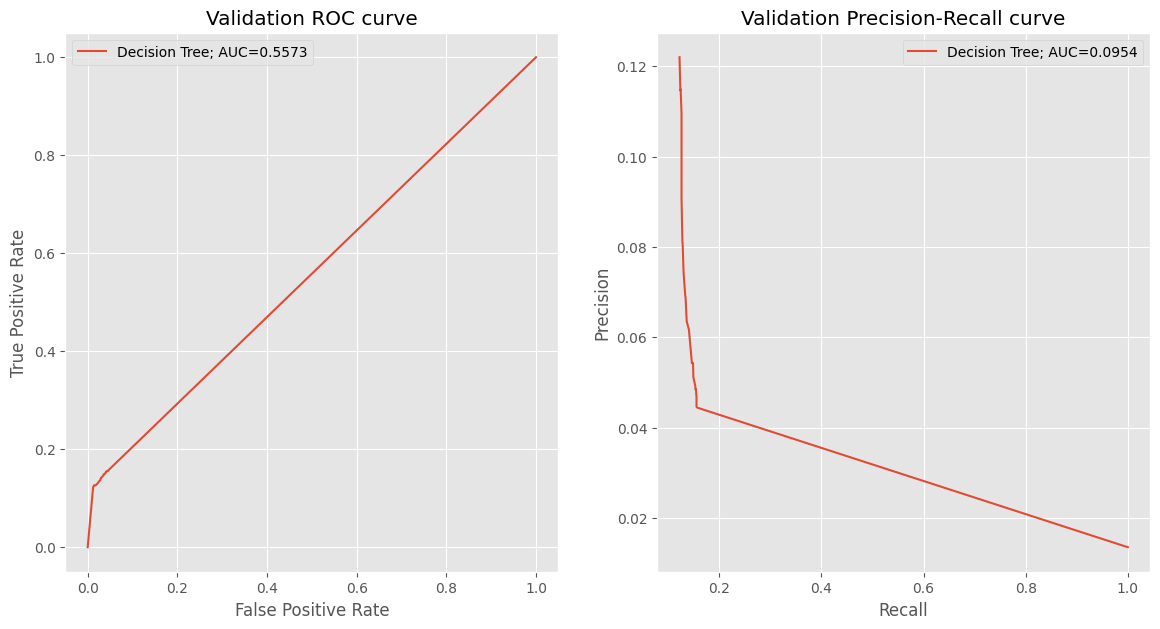

In [32]:
roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(Y_prob_dt, Y_validation)
plot_metrics('Decision Tree', roc, auc_roc, precision_recall, auc_precrec)

We can see that only one tree has poor results as its high variance. So now we will try bagging in order to reduce that variance and check if it has effect in the prediction

### BAGGING

We are not going to use CrossValidation because with so many data inside the dataset of trainning and validation, we decrease the chances of overfitting by reducing the variability of the dataset

However, this would be the code:

In [ ]:
# def split(df):
#     X = df.loc[:, train_columns]
#     y = df.loc[:, label_col]
#     groups = df.loc[:, "order_id"]
#     return X, y, groups

# X_train, y_train, groups_train = split(train)

# param_grid = {'n_estimators':[10, 100, 500, 1000], 'estimator__min_samples_leaf':[1, 3, 5]}
# GridSearchCV(bagging_model, param_grid, cv=sgkf.split(X_train, y_train, groups_train)

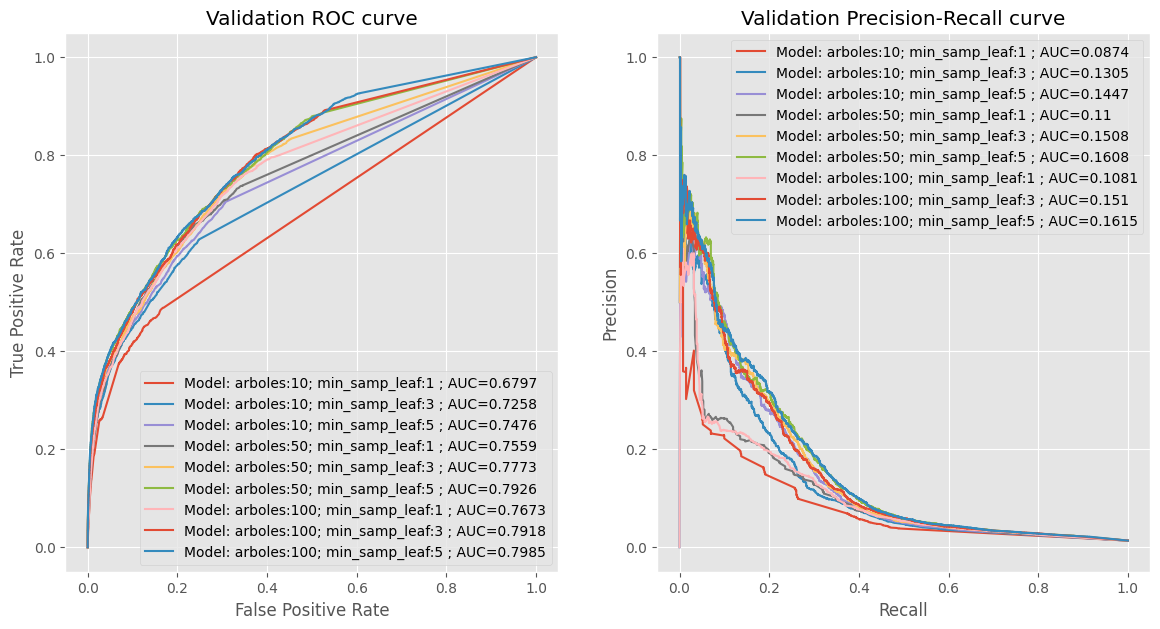

In [42]:
parameters = {'n_estimators': [10, 50, 100], 'min_samples_leaf': [1, 3, 5]}

fig, ax = plt.subplots(1, 2, figsize = (14,7))

for n_estimators in parameters['n_estimators']:
    for min_samples_leaf in parameters['min_samples_leaf']:
        base_model = tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
        bagging_model = ensemble.BaggingClassifier(base_model, n_estimators=n_estimators)
        bagging_model.fit(X_train[train_columns], Y_train)
        Y_prob_bag = bagging_model.predict_proba(X_validation[train_columns])[:,1]
        roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(Y_prob_bag, Y_validation)
        plot_metrics(f"Model: arboles:{n_estimators}; min_samp_leaf:{min_samples_leaf} ", roc, auc_roc, precision_recall, auc_precrec, figure=(fig,ax))

### Views:
- With more trees trained, we obtain better results. This is because we decrease the variance of the model by mantaining the bias, resulting in less error rate. 
- With less trees (10) the better results are obtained with min_samp_leaf value greater because is a way of regularization and decrease the high variance of a decision tree with 1 min_samp_leaf by a little cost of bias.
- As the difference between [50,5] and [100,5] aren´t big, we will conclude that the best model is of 50 trees and 5 min_sample_leaf. However, the results don't improve the ones obtained by linear models.

In [43]:
base_model = tree.DecisionTreeClassifier(min_samples_leaf=5)
bagging_model = ensemble.BaggingClassifier(base_model, n_estimators=50)
bagging_model.fit(X_train[train_columns], Y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(min_samples_leaf=5),
                  n_estimators=50)

In [37]:
Y_prob_bag = bagging_model.predict_proba(X_validation[train_columns])[:,1]

### RANDOM FOREST

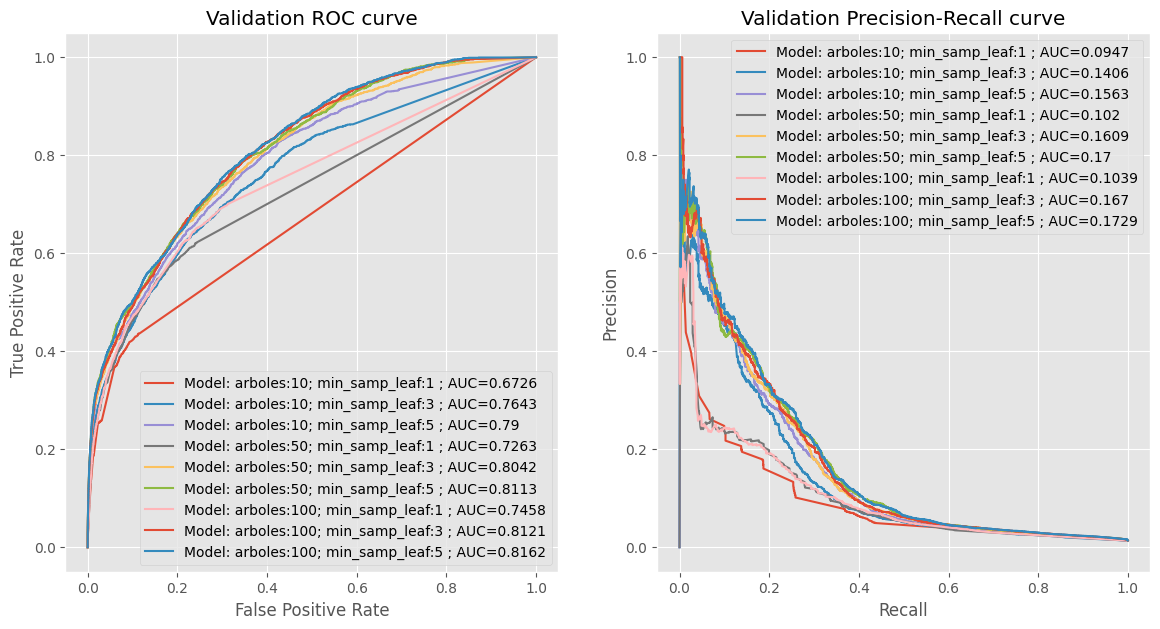

In [47]:
parameters = {'n_estimators': [10, 50, 100], 'min_samples_leaf': [1, 3, 5]}

fig, ax = plt.subplots(1, 2, figsize = (14,7))

for n_trees in parameters['n_estimators']:
    for msl in parameters['min_samples_leaf']:
        rf_model = ensemble.RandomForestClassifier(n_estimators=n_trees, min_samples_leaf=msl)
        rf_model.fit(X_train[train_columns], Y_train)
        Y_prob_rf = rf_model.predict_proba(X_validation[train_columns])[:,1]
        roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(Y_prob_rf, Y_validation)
        plot_metrics(f"Model: arboles:{n_trees}; min_samp_leaf:{msl} ", roc, auc_roc, precision_recall, auc_precrec, figure=(fig,ax))

The conclusions drawn from the graphs are very similar to those seen in bagging. However, a slight improvement can be observed with the random forest model thanks to the random selection of variables for each tree, which further reduces the variance of the model, and reducing the error.

In [48]:
rf_model = ensemble.RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
rf_model.fit(X_train[train_columns], Y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=500)

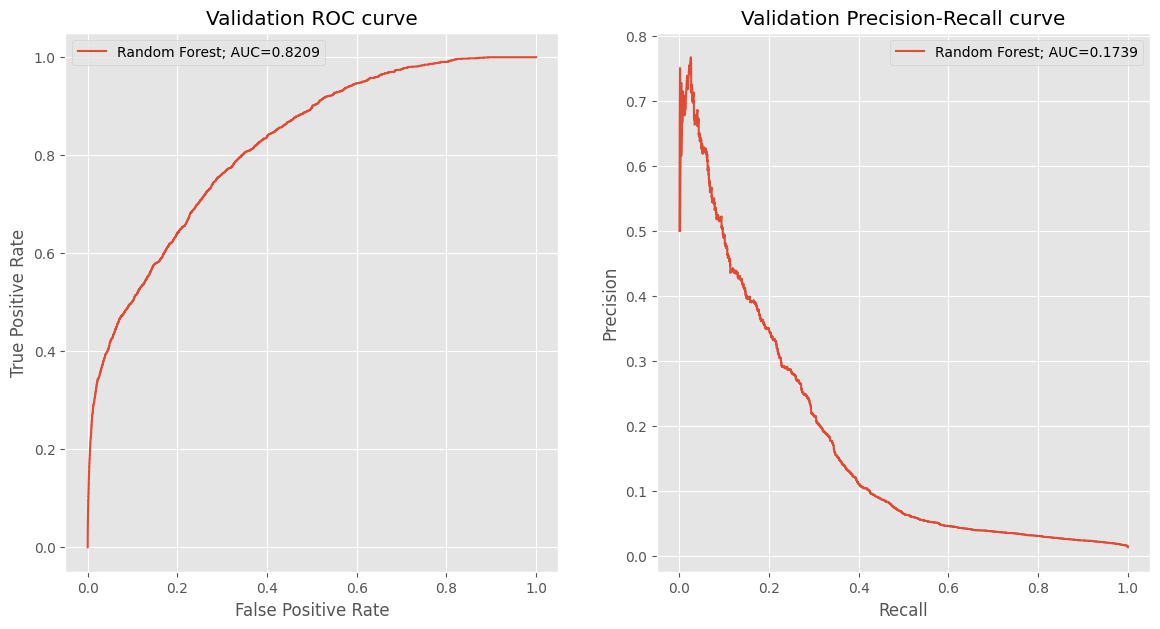

In [49]:
Y_prob_rf = rf_model.predict_proba(X_validation[train_columns])[:,1]
roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(Y_prob_rf, Y_validation)
plot_metrics('Random Forest', roc, auc_roc, precision_recall, auc_precrec)

With more trees, we obtain very little increase in results of the roc, but in the recall-precision, is insignificant, so there is no need to increase more than 50 trees

### GRADIENT BOOSTING

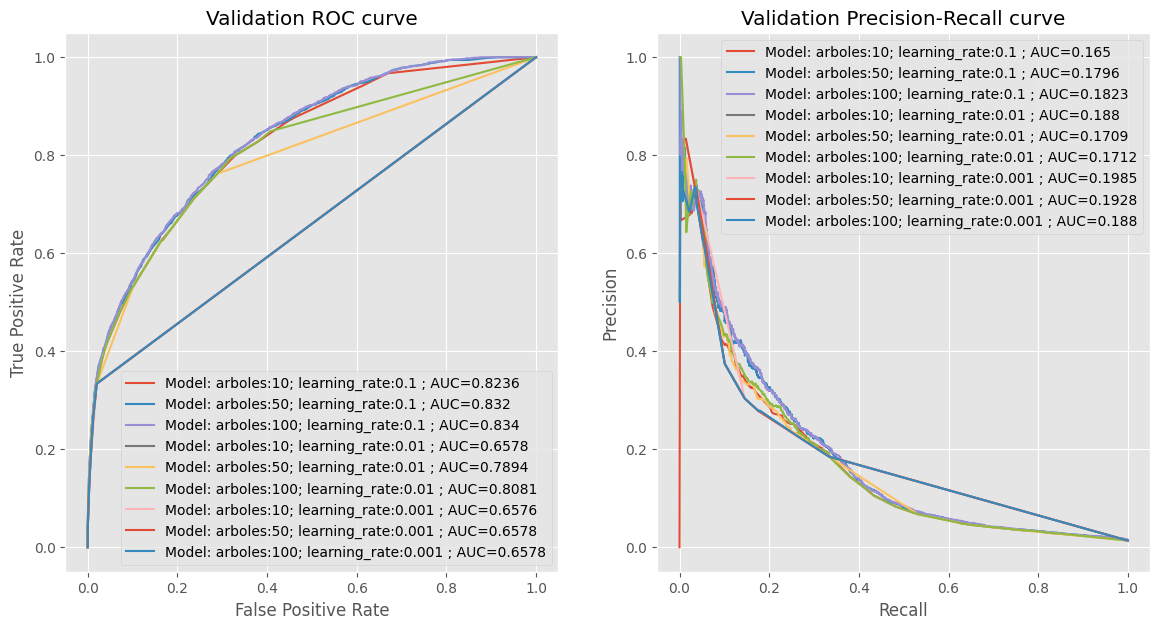

In [50]:
parameters = {'n_estimators': [10, 50, 100], 'learning_rate': [0.1, 0.01, 0.001]}

fig, ax = plt.subplots(1, 2, figsize = (14,7))

for lr in parameters['learning_rate']:
    for n_trees in parameters['n_estimators']:
        gboost_model = ensemble.GradientBoostingClassifier(learning_rate=lr, n_estimators=n_trees)
        gboost_model.fit(X_train[train_columns], Y_train)
        Y_prob_gboost = gboost_model.predict_proba(X_validation[train_columns])[:,1]
        roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(Y_prob_gboost, Y_validation)
        plot_metrics(f"Model: arboles:{n_trees}; learning_rate:{lr} ", roc, auc_roc, precision_recall, auc_precrec, figure=(fig,ax))

We can observe that greater learning_rate makes the model get worse results. This may be because with little number of trees and high learning_rate, it doesn´t allow to get to the minimum to the gradient. So in this cases we must have increased the number of trees a lot. 

However, with low learning_rates, and the number of trees tried, we have a little improve of the ROC and the recall-precision auc what it means we have the best results between all the tree models.

Nevertheless, I am would choose the linear models due to it's similar performace with these models and it's low use in computacional resources